<a href="https://colab.research.google.com/github/bensapirstein/DeepGraphemics/blob/main/2_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Variational Autoencoders (VAEs)
======

The VAE implemented here uses the setup found in most VAE papers: a multivariate Normal distribution for the conditional distribution of the latent vectors given and input image ($q_{\phi}(z | x_i)$ in the slides) and a multivariate Bernoulli distribution for the conditional distribution of images given the latent vector ($p_{\theta}(x | z)$ in the slides). Using a Bernoulli distribution, the reconstruction loss (negative log likelihood of a data point in the output distribution) reduces to the pixel-wise binary cross-entropy. See the [original VAE paper](https://arxiv.org/pdf/1312.6114.pdf), Appendix C.1 for details.

In [1]:
# install pytorch (http://pytorch.org/) if run from Google Colaboratory
import os
import sys
if 'google.colab' in sys.modules:
    if 'torch' not in sys.modules:
        !pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html
    if 'skia-python' not in sys.modules:
        !pip3 install skia-python

    if os.getcwd() != '/content/DeepGraphemics':
        !git clone https://github.com/bensapirstein/DeepGraphemics.git
        %cd DeepGraphemics/

ds_name = "rich_moderate"
letter = "aleph"
# root_dir = f"datasets/{ds_name}_ds"
root_dir = f"datasets/{ds_name}"
if not os.path.exists(root_dir):
    zipped_data = f"datasets/{ds_name}_{letter}.zip"
    !unzip $zipped_data -d $root_dir


%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F

Parameter Settings
-------------------


In [7]:
from configs.config import vae_config

# 2-d latent space, parameter count in same order of magnitude
# as in the original VAE paper (VAE paper has about 3x as many)
latent_dims = 2
vae_config.latent_dims = latent_dims
vae_config.capacity = 64
vae_config.variational_beta = 1

num_epochs = 100
batch_size = 128
learning_rate = 1e-3
use_gpu = True

Data Loading
-------------------

GraphemesDataset images show letters from 13 writing systems in 28x28 grayscale images. We do not center them at 0, because we will be using a binary cross-entropy loss that treats pixel values as probabilities in [0,1]. We create both a training set and a test set.

In [8]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from src.datasets import GraphemesDataset

img_transform = transforms.Compose([
    transforms.ToTensor()
])

letter = 'aleph'

train_dataset = GraphemesDataset(root_dir, train=True, by_letter=letter, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = GraphemesDataset(root_dir, train=False, by_letter=letter, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

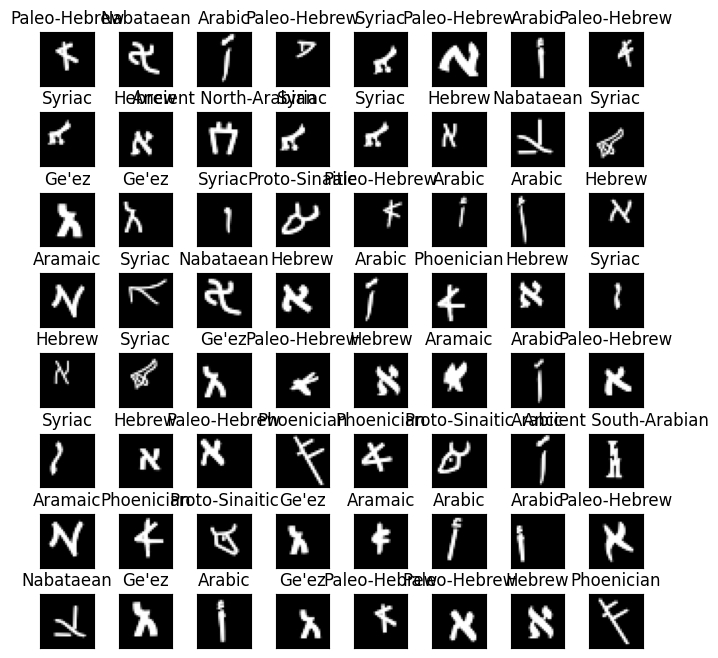

In [ ]:
import src.plot as plot

fig, axes = plot.dataset_first_n(train_dataset, 64, 
                                 show_classes=True, 
                                 class_labels=train_dataset.classes,
                                 nrows=8, hspace=0.5, cmap='gray')

VAE Definition
-----------------------
We use a convolutional encoder and decoder, which generally gives better performance than fully connected versions that have the same number of parameters.

In convolution layers, we increase the channels as we approach the bottleneck, but note that the total number of features still decreases, since the channels increase by a factor of 2 in each convolution, but the spatial size decreases by a factor of 4.

Kernel size 4 is used to avoid biasing problems described here: https://distill.pub/2016/deconv-checkerboard/

In [5]:
from models.vae import VariationalAutoencoder

vae = VariationalAutoencoder(vae_config)

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 308357


Train VAE
--------

In [ ]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
vae.train()

train_loss_avg = []
print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0

    print(f"*** Running vae on {len(train_dataset)} samples in {len(train_dataloader)} batches")

    for image_batch, _ in train_dataloader:

        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss = vae.loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()

        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()

        train_loss_avg[-1] += loss.item()
        num_batches += 1

    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Plot Training Curve
--------------------

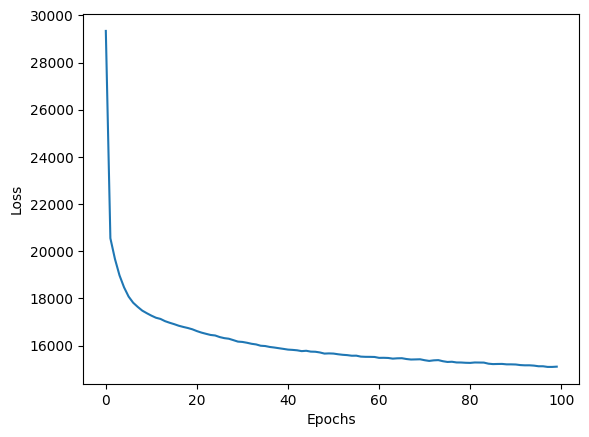

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
save the model
if not os.path.exists('./pretrained_models'):
    os.mkdir('./pretrained_models')
torch.save(vae.state_dict(), f'./pretrained_models/{letter}_vae_{latent_dims}_dims.pth')

Alternatively: Load Pre-Trained VAE
-----------------------------

In [6]:
# filename = f'{letter}_vae_{latent_dims}_dims.pth'
# import urllib
# # load on cpu
# vae.load_state_dict(torch.load('./pretrained_models/'+filename, map_location=device))
# print('done')

done


Evaluate on the Test Set
-------------------------

In [ ]:
# set to evaluation mode
vae.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:

    with torch.no_grad():

        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss = vae.loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        test_loss_avg += loss.item()
        num_batches += 1

test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 15514.535547


Visualize Reconstructions
--------------------------

Original images


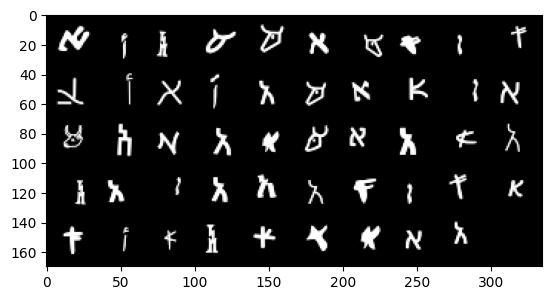

VAE reconstruction:


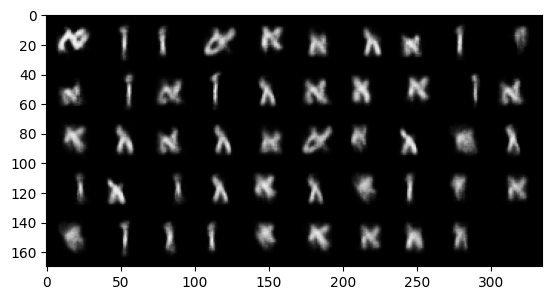

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():

        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

dataiter = iter(test_dataloader)
images, labels = next(dataiter)

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)

Interpolate in Latent Space
----------------------------

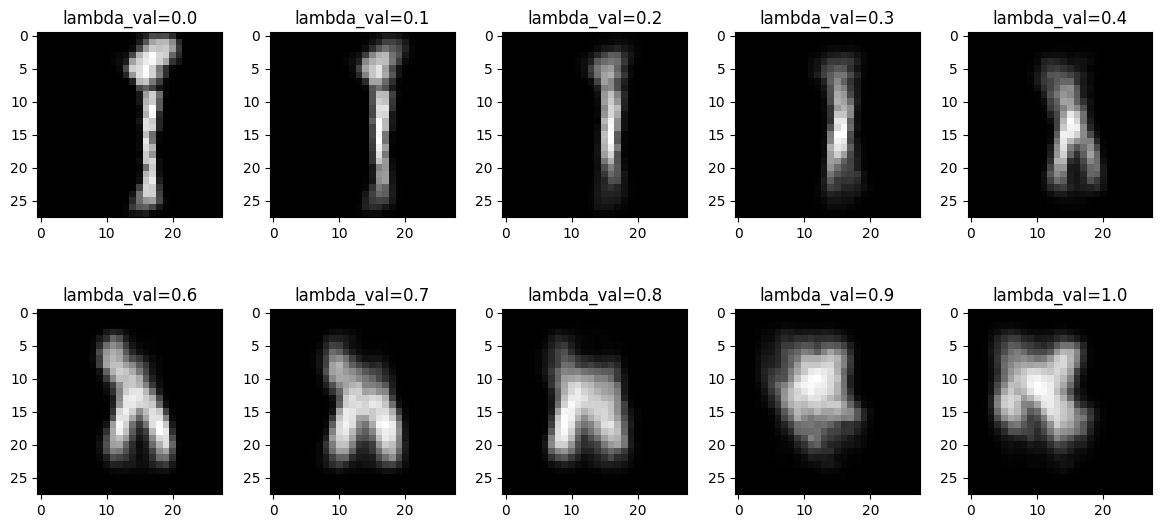

In [ ]:
vae.eval()

def interpolation(lambda1, model, img1, img2):

    with torch.no_grad():

        # latent vector of first image
        img1 = img1.to(device)
        latent_1, _ = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2, _ = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

# sort part of test set by writing system
scripts = [[] for _ in range(len(train_dataset.classes))]
for img_batch, label_batch in test_dataloader:
    for i in range(img_batch.size(0)):
        scripts[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in scripts) >= 1000:
        break;

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), vae, scripts[6][0], scripts[2][0])

    inter_image = to_img(inter_image)

    image = inter_image.numpy()

    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show()

Sample Latent Vector from Prior (VAE as Generator)
-------------------------------------------------

A VAE can generate new digits by drawing latent vectors from the prior distribution. Although the generated digits are not perfect, they are usually better than for a non-variational Autoencoder (compare results for the 10d VAE to the results for the autoencoder).

Similar to autoencoders, the manifold of latent vectors that decode to valid digits is sparser in higher-dimensional latent spaces. Increasing the weight of the KL-divergence term in the loss (increasing `variational_beta`) makes the manifold less sparse at the cost of a lower-quality reconstruction. A pre-trained model with `variational_beta = 10` is available at `./pretrained/vae_10d_beta10.pth`.

In [ ]:
vae.eval()

with torch.no_grad():

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, latent_dims, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(5, 5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()

KeyboardInterrupt: 

Show 2D Latent Space
---------------------

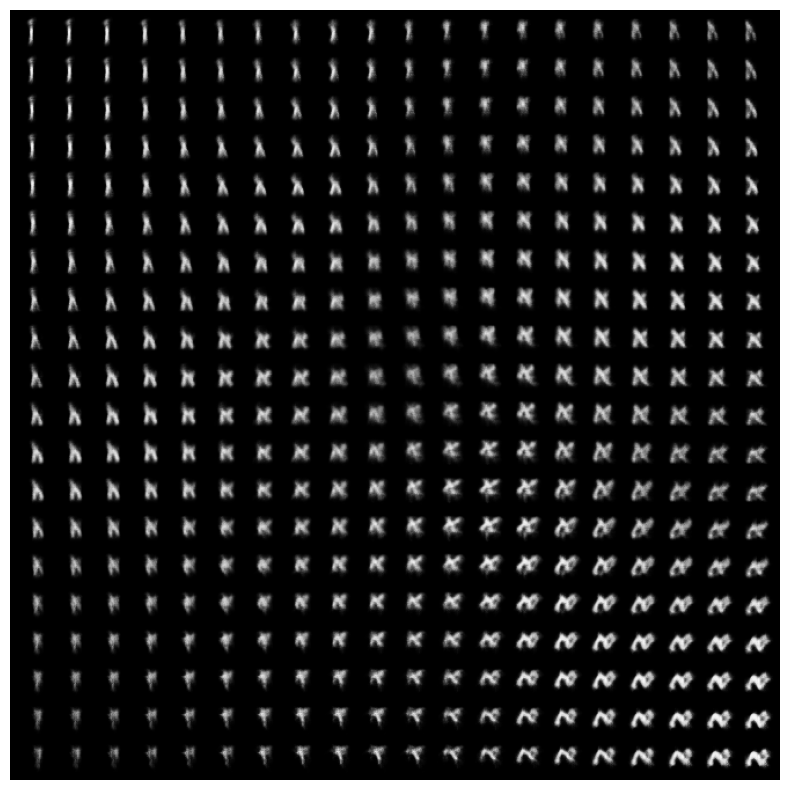

In [ ]:
# load a network that was trained with a 2d latent space
if latent_dims != 2:
    print('Please change the parameters to two latent dimensions.')

with torch.no_grad():

    # create a sample grid in 2d latent space
    apothem = 1.5
    latent_x = np.linspace(-apothem,apothem,20)
    latent_y = np.linspace(-apothem,apothem,20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    latents = latents.to(device)
    image_recon = vae.decoder(latents)
    image_recon = image_recon.cpu()

    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(image_recon.data[:400],20,5))
    # remove axis labels
    plt.axis('off')
    plt.show()